# Load in the data - X-Fact

In [4]:
import pandas as pd
import os
os.chdir(r'C:\Users\annal\OneDrive\Desktop\llm-misinfo-eval\data')  #this line is what I've been using to solve a no such directory error - copy paste the path of data folder
df = pd.read_csv(r"x_fact_dataset/x-fact-including-en/train.all.tsv", delimiter="\t", on_bad_lines="skip")



# Get results from Cohere

In [21]:
import cohere
from dotenv import load_dotenv
load_dotenv(r'C:\Users\annal\OneDrive\Desktop\llm-misinfo-eval\cohere.env')
key = os.getenv('Cohere_API_Key')
co = cohere.Client(key) 

In [22]:
import time
from tqdm import trange

cohere_resp = []

for i in trange(1000):
    tmp = {"cohere_resp":None, "index":i, "label":df["label"][i]}
    claim = df["claim"][i]
    try:
        response = co.chat(
            message=f"Rate the truthfulness of the following statement: {claim} Provide a score from 0 to 100, where 0 represents definitively false and 100 represents definitively true. Do not provide any explanations, only respond with the numerical score.",
            connectors=[{"id": "web-search"}]
        )
        tmp["cohere_resp"] = response.text
        cohere_resp.append(tmp)
    except cohere.CohereAPIError: #looks like we got an error because there were too many tokens in a query, so i'm going to just bypass such cases
        #alternatively: the default is a model with max 4096 tokens, but we could go up to 8192 (however, those models are less stable)
        continue
    time.sleep(1)

100%|██████████| 1000/1000 [2:14:35<00:00,  8.08s/it] 


In [23]:
import termcolor
df_results0 = pd.DataFrame(cohere_resp)
df_results0.info()
df_results0.tail()

# for i in range(df_results0.shape[0]):
#     print(termcolor.colored("Claim language: ", "green")+df["language"][i])
#     true_label = df_results0["label"][i]
#     print(termcolor.colored("True label: ","magenta")+ termcolor.colored(true_label,"magenta"))
#     print(termcolor.colored("Zero-Shot Response: ", "cyan")+df_results0["cohere_resp"][i])
#     print("\n---\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cohere_resp  996 non-null    object
 1   index        996 non-null    int64 
 2   label        987 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


,cohere_resp,index,label
991,85,995,partly true/misleading
992,95,996,partly true/misleading
993,95,997,false
994,"This statement is mostly true, albeit with som...",998,complicated/hard to categorise
995,84,999,partly true/misleading


# Saving Cohere's Responses to CSV
Don't want to have to repeat the calls to cohere if we want to do more analysis on the same data!

In [24]:
df_results0.to_csv("cohere_results", sep=',', index=False, encoding='utf-8')

# Recovering Old Results

In [36]:
df_results0 = pd.read_csv(r"cohere_results", delimiter=",", on_bad_lines="skip")

# Analysis

# Overall Characteristics and Performance

In [37]:
#first, check language distribution and label distribution
extracted_col = df["language"].head(1000)
df_results0 = pd.concat([df_results0, extracted_col.rename("language")], axis=1)
df_results0["language"].value_counts()



language
pt    318
id    117
ar     92
ka     89
pl     71
ta     59
hi     57
it     55
tr     42
de     38
sr     32
ro     30
Name: count, dtype: int64

In [38]:
#label distribution
df_results0["label"].value_counts()

label
false                             376
partly true/misleading            248
true                              204
mostly true                        71
mostly false                       51
complicated/hard to categorise     24
other                              13
Name: count, dtype: int64

In [39]:
#simplify the truth-value to binary, so we can approximate some accuracy by delineating false as anything below 50
def simplify_truth(row):
    if row['label'] in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 'false'
    else:
        return 'true'
    

df_results0['simple_truth'] = df_results0.apply(simplify_truth, axis=1)

df_results0["simple_truth"].value_counts() #much more false than true


simple_truth
false    675
true     325
Name: count, dtype: int64

In [40]:
#simplify cohere response to a binary truth-value
def cohere_tv(row):
    resp = row['cohere_resp']

    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp > 50: #TODO: tune this value?
        return "true"
    
    else:
        return "false"
    

df_results0['cohere_simple'] = df_results0.apply(cohere_tv, axis=1)

df_results0.head()

,cohere_resp,index,label,language,simple_truth,cohere_simple
0,56,0.0,false,tr,false,true
1,15,1.0,partly true/misleading,ka,false,false
2,85,2.0,partly true/misleading,pt,false,true
3,85,3.0,true,ka,true,true
4,I'm sorry but I was unable to find any relevan...,4.0,false,id,false,unknown


In [64]:
import numpy as np
import matplotlib.pyplot as plt

#check if cohere results match, by language

#make a new column for whether cohere matches by language
def match_tv(row):
    if row['simple_truth'] == row['cohere_simple']:
        return 1
    else:
        return 0

df_results0['match'] = df_results0.apply(match_tv, axis=1)


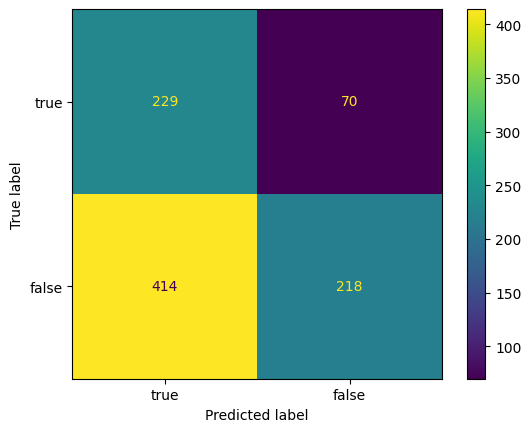

In [45]:

import sklearn.metrics as skm

skm.ConfusionMatrixDisplay.from_predictions(df_results0["simple_truth"], df_results0["cohere_simple"], labels=["true", "false"])

#looks like we have a lot of false negatives - a lot of misinfo is being classified as true
#interestingly, cohere is predicting true more often than it's predicting false, but there are actually more false claims in the dataset


In [61]:
#normal accuracy
skm.accuracy_score(df_results0["simple_truth"], df_results0["cohere_simple"])

0.447

In [63]:
#f1
skm.f1_score(df_results0["simple_truth"], df_results0["cohere_simple"], labels=["true", "false"], average=None)

array([0.4731405 , 0.45275182])

In [48]:
#balanced accuracy
skm.balanced_accuracy_score(df_results0["simple_truth"], df_results0["cohere_simple"], adjusted=False) #changing the adjusted parameter has a HUGE effect - why?

c:\Users\annal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.5137891737891738

In [59]:
#precision
skm.precision_score(df_results0["simple_truth"], df_results0["cohere_simple"], labels=["true", "false"], average=None) #won't work if you set average to binary, even though the class is binary 
#(I think because there are "unknown" values in cohere, and you can't filter them out in binary)
#precision for true: 0.35 (lots of false positives - lots of false claims being classified as true)
#precision for false: 0.75 (comparatively fewer false negatives)

array([0.35614308, 0.75694444])

In [60]:
#recall
skm.recall_score(df_results0["simple_truth"], df_results0["cohere_simple"], labels=["true", "false"], average=None) 
#recall for true: 0.70 (relatively good jub finding all true samples without misclassifying them as false)
#recall for false: 0.32 (we are not guessing that a lot of samples are false)


array([0.70461538, 0.32296296])

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\1302075777.py:10: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_understood = df_results0.groupby("language")["understood"].agg(np.mean)


<Axes: title={'center': 'Task Understanding by language'}, xlabel='language'>

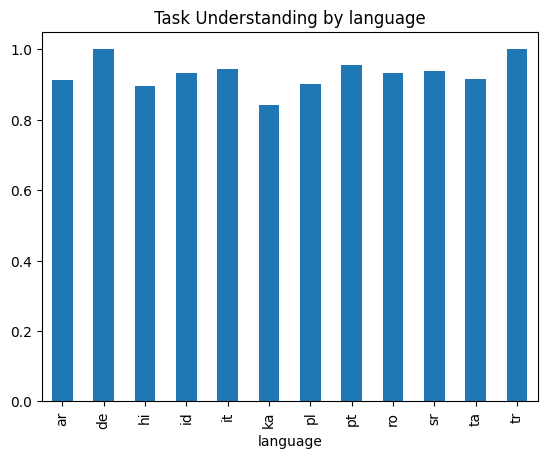

In [72]:
#looking at how well cohere understood the task and responded as it was supposed to
def task_understood(row):
    if row['cohere_simple'] == 'unknown':
        return 0
    else:
        return 1
    
df_results0['understood'] = df_results0.apply(task_understood, axis=1)

df_understood = df_results0.groupby("language")["understood"].agg(np.mean)

df_understood.plot.bar("understood", title="Task Understanding by language")

# Investigating Differences Between Languages

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\3695656161.py:2: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_simple = df_results0.groupby("language")["match"].agg(np.mean)


<Axes: title={'center': 'Accuracy by Language'}, xlabel='language'>

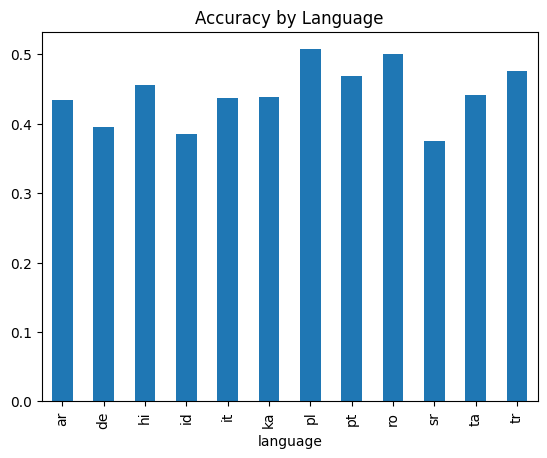

In [66]:
#1 means everything was right, 0 means everything was wrong (since a 1 was added for a match, a 0 was added otherwise)
df_simple = df_results0.groupby("language")["match"].agg(np.mean)

df_simple.plot.bar("match", title="Accuracy by Language") #match corresponds to accuracy, as (num correct) / (num total)


In [74]:
#make a new column for whether cohere matches by language
def euro_or_not(row):
    if row['language'] in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]: #german, spanish, french, italian, norwegian, dutch, polish
        return "european"
    else: #ar - arabic; az - azerbaijani; bn - bengali; fa - farsi; gu - gujarati; hi - hindi; id - indonesian
        #ka - georgian; mr - marathi; pa - punjabi; si - sinhala; ta - tamil; tr - turkish
        return "non-european"

df_results0['euro'] = df_results0.apply(euro_or_not, axis=1)
df_results0["euro"].value_counts() #doesn't seem tooooo crazy a difference


euro
european        544
non-european    456
Name: count, dtype: int64

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\2133480615.py:2: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_euro = df_results0.groupby("euro")["match"].agg(np.mean)


<Axes: title={'center': 'Accuracy by European/Non-European Language'}, xlabel='euro'>

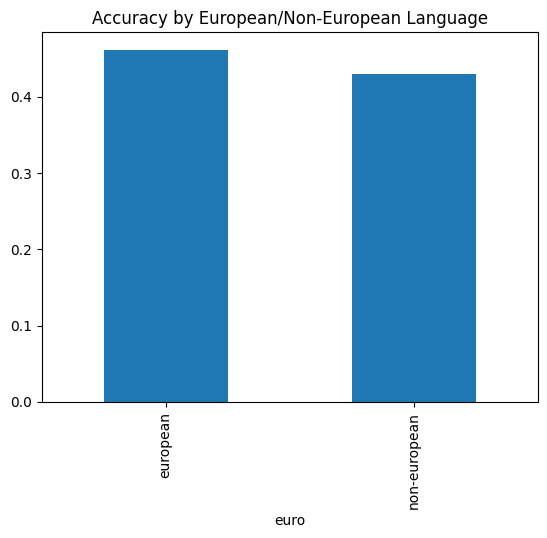

In [75]:
#1 means everything was right, 0 means everything was wrong (since a 1 was added for a match, a 0 was added otherwise)
df_euro = df_results0.groupby("euro")["match"].agg(np.mean)
df_euro.plot.bar("match", title="Accuracy by European/Non-European Language")

In [78]:
#european vs non-european doesn't seem that significant - what if we try only the western european languages?
def western(row):
    if row["language"] in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return "western"
    else:
        return "non-western"

df_results0["western"] = df_results0.apply(western, axis=1)
df_results0["western"].value_counts() #again, not orders of magnitude of difference



western
non-western    589
western        411
Name: count, dtype: int64

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\3264775400.py:1: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_western = df_results0.groupby("western")["match"].agg(np.mean)


<Axes: title={'center': 'Accuracy by Western European/Non Western European Language'}, xlabel='western'>

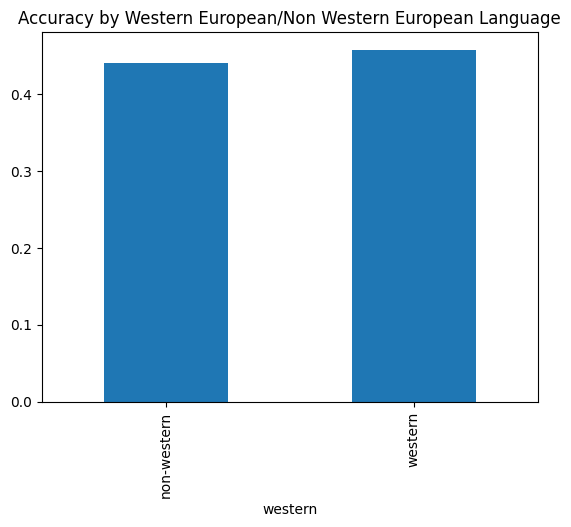

In [79]:
df_western = df_results0.groupby("western")["match"].agg(np.mean)
df_western.plot.bar("match", title="Accuracy by Western European/Non Western European Language")

In [80]:
#languages by size (https://en.wikipedia.org/wiki/List_of_languages_by_total_number_of_speakers)
#<45 m: no, nl, pl, ro, sr, sq, az, ka, si
#>45 m: de, es, fr, it, pt, ru, ar, bn, fa, gu, hi, id, mr, pa, ta, tr
def small(row):
    if row["language"] in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return "small"
    else:
        return "large"

df_results0["size"] = df_results0.apply(small, axis=1)
df_results0["size"].value_counts() #much fewer small languages


size
large    778
small    222
Name: count, dtype: int64

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\1950631918.py:1: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_size = df_results0.groupby("size")["match"].agg(np.mean)


<Axes: title={'center': 'Accuracy for languages with more or less than 45 million speakers'}, xlabel='size'>

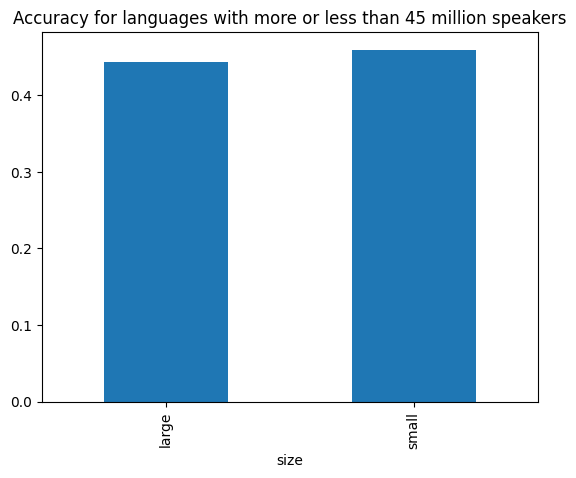

In [81]:
df_size = df_results0.groupby("size")["match"].agg(np.mean)
df_size.plot.bar("match", title="Accuracy for languages with more or less than 45 million speakers")

# Giving Cohere a little help?
In most cases where Cohere doesn't provide a numerical answer, it provides an answer with some explanation (which we didn't want) and the score, usually in a sentence like "I give this claim a score of...". Let's try to use that data:

In [9]:
import re

def cohere_tv_help(row):
    resp = row['cohere_resp']

    try:
        resp = float(resp)
    except ValueError:
        resp_helped = re.findall(r"(score of )([1-90]+)", resp) #this is going to cut off decimal points - but do they really matter?
        if resp_helped == []:
            return 'unknown'
        (x, score)= resp_helped[0] #really we should only see one, and we need to look at the second element of the pattern(which should be the score
        resp = float(score)
        
    
    if resp > 50:
        return "true"
    
    else:
        return "false"
    
df_results0['cohere_simple_helped'] = df_results0.apply(cohere_tv_help, axis=1)
    
def match_tv_helped(row):
    if row['simple_truth'] == row['cohere_simple_helped']:
        return 1
    else:
        return 0

df_results0['match_helped'] = df_results0.apply(match_tv_helped, axis=1)
df_simple = df_results0.groupby("language")[["match_helped", "match"]].agg(np.mean)

df_simple.head(50) #we don't appear to be seeing any meaningful change in accuracy - but was there a change in understanding?

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\525987105.py:31: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_simple = df_results0.groupby("language")[["match_helped", "match"]].agg(np.mean)


,match_helped,match
language,,
ar,0.434783,0.434783
de,0.394737,0.394737
hi,0.473684,0.456140
id,0.384615,0.384615
it,0.436364,0.436364
ka,0.449438,0.438202
pl,0.507042,0.507042
pt,0.477987,0.468553
ro,0.533333,0.500000


In [15]:
#looking at how well cohere understood the task and responded as it was supposed to
def task_understood_help(row):
    if row['cohere_simple_helped'] == 'unknown':
        return 0
    else:
        return 1
    
df_results0['understood_help'] = df_results0.apply(task_understood_help, axis=1)

df_understood = df_results0.groupby("language")[["understood", "understood_help", "match", "match_helped"]].agg(np.mean)

df_understood.head(50) #we can now see a change in understanding! so we are seeing that for some languages (ka, pl, pt, ro, tr), there is a change in understanding (ie we extracted a score), but no change in accuracy (ie that score was wrong)
#in fact, all languages that had to be "helped" were wrong in their predictions
#df_understood.plot.bar("understood_help", title="Task Understanding by language after help")

C:\Users\annal\AppData\Local\Temp\ipykernel_26824\1819495573.py:10: FutureWarning: The provided callable <function mean at 0x00000199AAA0CE00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_understood = df_results0.groupby("language")[["understood", "understood_help", "match", "match_helped"]].agg(np.mean)


,understood,understood_help,match,match_helped
language,,,,
ar,0.913043,0.913043,0.434783,0.434783
de,1.000000,1.000000,0.394737,0.394737
hi,0.894737,0.912281,0.456140,0.473684
id,0.931624,0.931624,0.384615,0.384615
it,0.945455,0.963636,0.436364,0.436364
ka,0.842697,0.865169,0.438202,0.449438
pl,0.901408,0.929577,0.507042,0.507042
pt,0.955975,0.977987,0.468553,0.477987
ro,0.933333,0.966667,0.500000,0.533333


In [ ]:
#TODO: label distribution, language distribution, try changing collapsing, precision and recall